## In-Depth Analysis of a Single Portfolio Strategy

This notebook focuses on analyzing the performance of one specific portfolio strategy across selected stocks or ETFs and time periods. It is designed to help you understand how the strategy behaves in terms of growth, volatility, and capital allocation.

For this example, we use the popular **Mean Variance Optimization** strategy by **Markowitz** which ignites the start of modern portfolio theory.

Note: The strategy includes a tunable hyperparameter for risk aversion and, you can experiment with different values to observe their effect on performance.

In [9]:
# Import necessary libraries and modules
import sys
import os

# Add parent directory to sys.path so you can import from data, strategies, evaluation, and backtesting modules
sys.path.append(os.path.abspath(".."))

from data import (
    DataLoader,
    build_cash_benchmark,
    build_rf_benchmark,
    build_spy_benchmark,
    build_custom_benchmark,
)

from backtesting import Backtester

from strategies import (
    MeanVarianceOptimizationStrategy,
    # Whatever other strategies you want to include
)

from evaluation import (
    plot_strategy,
)


import numpy as np
import pandas as pd

## 🧪 Backtesting a Portfolio Strategy: Setup

This section sets up the necessary components to backtest a portfolio strategy using a custom selection of assets.

- **Step 1:** Define your universe of stocks or ETFs. In this example, we use large-cap tech stocks.
- **Step 2:** Fetch historical price data using a custom `DataLoader` class. You can adjust the start date and frequency (e.g. monthly).
- **Step 3:** Specify the initial capital and how it's allocated across the assets.
- **Step 4:** Define how much new cash is added at each rebalancing period (e.g. monthly contributions).
- **Step 5:** Instantiate one or more strategies (e.g. Mean-Variance Optimization).
- **Step 6:** Run the backtest using the `Backtester`, which will simulate the portfolio evolution over time.

Once the backtest completes, you can analyze the results and compare strategy performance.

In [10]:
# 1a) Define your universe and fetch prices (incl. SPY for benchmark)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
tickers = [
    "SPY", 
    "QQQ",
    "SMH"
]

# 1b) Load historical prices for the tickers
# You can adjust the start date and interval as needed
loader  = DataLoader(tickers, start='2023-01-01', interval='1mo')
prices = loader.fetch_prices()

# 2) Set up initial allocation: e.g. $x equally split across the n stocks
n = len(tickers)
initial_capital    = 0
initial_allocation = np.array([initial_capital / n] * n)

# 3) How much new cash to add each rebalance period?
monthly_cash = 1_000

# 4) Instantiate your strategies
strategies = {
    'MVO': MeanVarianceOptimizationStrategy(tickers, risk_aversion=0.2, lookback=6),
}

# 5) Wire up and run the backtest
bt = Backtester(
    strategies         = strategies,
    prices             = prices,
    initial_allocation = initial_allocation,
    monthly_cash       = monthly_cash,
)

results = bt.run()

## 📊 Creating Benchmark Portfolios

To evaluate your strategy's performance, it's important to compare it against various benchmark portfolios. This section sets up a few different types of benchmarks:

- **Cash benchmark:** Simulates simply saving the monthly contributions without any return.
- **Risk-free benchmark:** Models a savings account with interest (e.g. 1.25% annual rate).
- **Market benchmark (S&P 500):** Tracks the performance of investing in the SPY ETF with monthly contributions.
- **ETF benchmark (3-ETF strategy):** Diversifies contributions across multiple ETFs (e.g. SPY, QQQ, VYM).
- **Custom benchmark:** You can define your own mix of ETFs or stocks with custom weights to reflect your own investment approach.

All benchmarks assume the same cash flow: an initial capital and fixed monthly contributions. These are invested over time according to the benchmark's rules and weights.

The results are combined into a single DataFrame for easy comparison with your strategy's performance.

In [ ]:
## Create benchmarks

# Savings
dates = results['MVO']['total_values'].index
cash_benchmark = build_cash_benchmark(dates, initial_capital, monthly_cash)

# Bank saving account with interest rate (risk free rate) of 1.25% (as per ABN AMRO, 2025)
bank_benchmark = build_rf_benchmark(dates, initial_capital, monthly_cash, rf_rate=0.0125)

# S&P 500 benchmark 
spy_benchmark = build_spy_benchmark(dates, initial_capital, monthly_cash)

# ETF benchmark 
# 3 ETF strategy
# SPY: S&P 500 ETF   (50% weight)
# QQQ: Technlogy ETF (40% weight)
# VYM: Dividend ETF  (10% weight)
etfs = ['SPY', 'QQQ', 'VYM']
etf_benchmark = build_custom_benchmark(dates, initial_capital, monthly_cash, etfs, weights=[0.6, 0.4, 0.0])

#
# You can build a custom benchmark with different ETFs or stocks to compare against
# Each monthly cash inflow is added to the benchmark portfolio based on the defined weights (e.g., 50% SPY, 40% QQQ, 10% VYM)
#
custom_benchmark = build_custom_benchmark(dates, initial_capital, monthly_cash, etfs=['SPY', 'QQQ', 'SMH'], weights=[0.2, 0.3, 0.5])

# Combine all benchmarks into a single DataFrame
benchmarks = pd.concat([cash_benchmark, bank_benchmark, spy_benchmark, etf_benchmark, custom_benchmark], axis=1)

## 📈 Visualizing Strategy Performance

This section visualizes how the selected portfolio strategy performs over time using a 4-panel plot:

1. **Portfolio & Component Values**  
   Shows the total value of the portfolio and the value of each asset individually. Benchmarks are also shown for comparison, with final cumulative returns in parentheses.

2. **Allocation Evolution**  
   Displays how the dollar amount allocated to each asset changes over time.

3. **Weight Evolution**  
   Plots the weight (as a percentage of the portfolio) of each asset over time. This reflects the influence of market movements and rebalancing.

4. **Cumulative Return vs. Benchmarks**  
   Compares the portfolio's cumulative return (%) against the chosen benchmarks, adjusting for invested capital.

You can run `plot_strategy(...)` on any strategy result dictionary to get an in-depth view of its behavior over time.

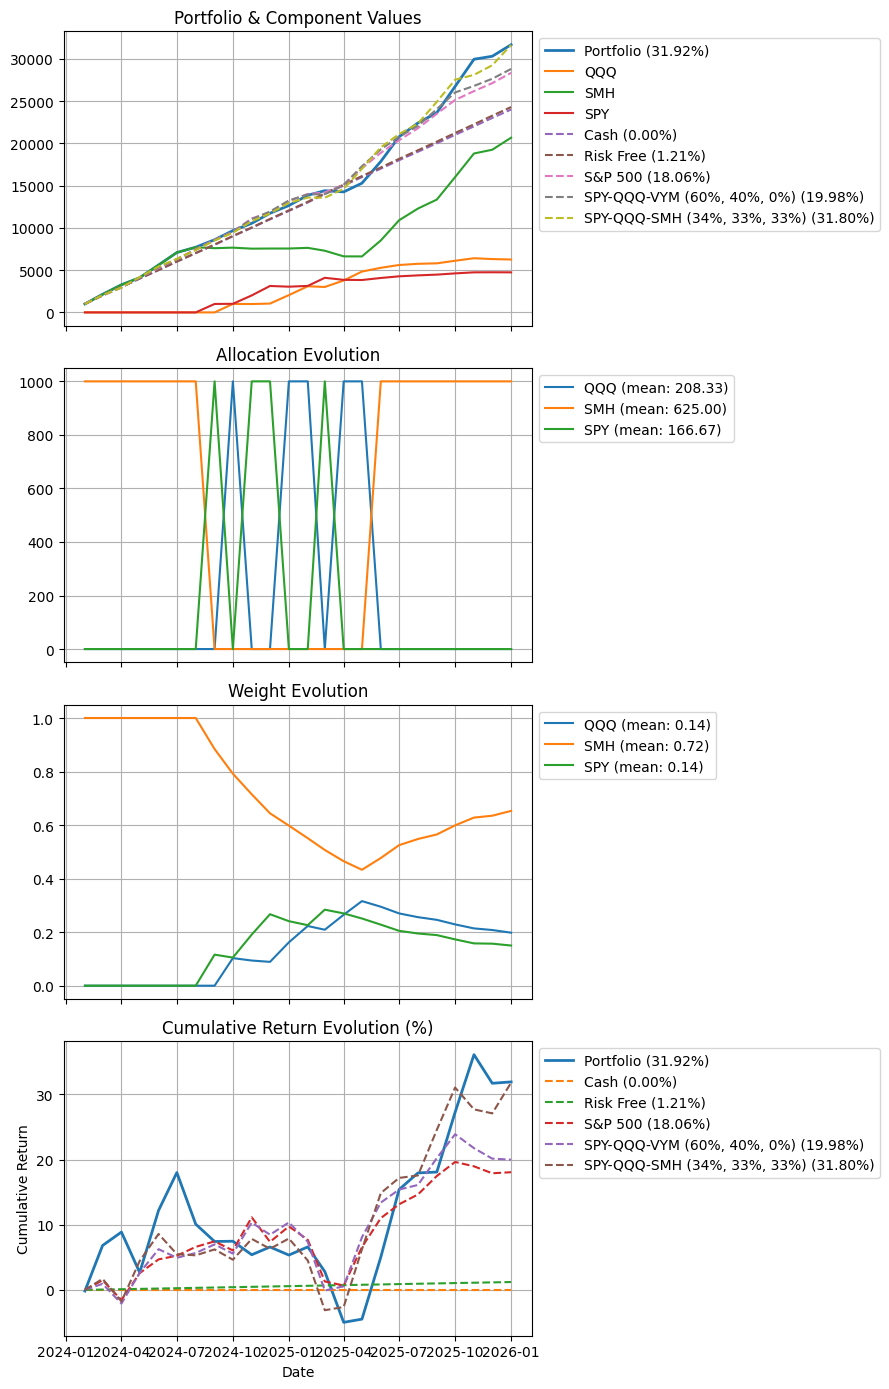

In [12]:
plot_strategy(results['MVO'], initial_capital, monthly_cash, benchmarks)